In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("data/gaze_positions.csv")

In [3]:
data.head()

,timestamp,index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,eye_center0_3d_z,gaze_normal0_x,gaze_normal0_y,gaze_normal0_z,eye_center1_3d_x,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z
0,2068.225736,0,0.650270,0.448057,0.264802,2068.225736-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2068.234136,0,0.742758,0.448100,0.266096,2068.234136-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2068.242536,0,0.718833,0.448159,0.267916,2068.242536-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2068.250936,0,0.580725,0.448509,0.269176,2068.250936-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2068.259336,0,0.621873,0.448495,0.270936,2068.259336-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
core = data[["timestamp", "confidence", "norm_pos_x", "norm_pos_y"]]

In [5]:
core.head()

,timestamp,confidence,norm_pos_x,norm_pos_y
0,2068.225736,0.650270,0.448057,0.264802
1,2068.234136,0.742758,0.448100,0.266096
2,2068.242536,0.718833,0.448159,0.267916
3,2068.250936,0.580725,0.448509,0.269176
4,2068.259336,0.621873,0.448495,0.270936


In [6]:
from matplotlib import pyplot as plt
%matplotlib notebook

In [7]:
from mpl_toolkits import mplot3d

In [8]:
from pykalman import KalmanFilter

In [9]:
kf = KalmanFilter(initial_state_mean=0.5, n_dim_obs=2)

In [10]:
xy = data[["norm_pos_x", "norm_pos_y"]].values

In [11]:
xy[1:10]

array([[0.44809971, 0.26609635],
       [0.448159  , 0.26791572],
       [0.44850883, 0.26917641],
       [0.44849496, 0.27093639],
       [0.44827076, 0.27285433],
       [0.44840316, 0.27538407],
       [0.44839952, 0.27528453],
       [0.44818918, 0.27641514],
       [0.38839063, 0.2171922 ]])

In [12]:
from pykalman import KalmanFilter
kf = KalmanFilter(initial_state_mean=[1,1.5],n_dim_obs=2)
output = kf.em(xy[:1000]).smooth(xy[:1000])

In [13]:
xy_new = output[0]
x_pred = xy_new[:,0]
y_pred = xy_new[:,1]

In [14]:
ts = data["timestamp"].values[:1000]

In [15]:
ts.shape

(1000,)

<IPython.core.display.Javascript object>


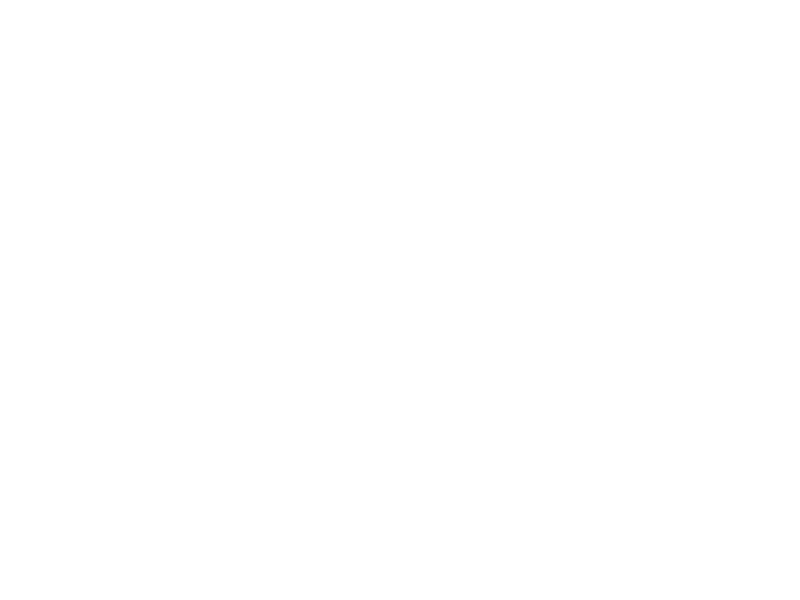

In [16]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(ts[0:50],data["norm_pos_x"][0:50], data["norm_pos_y"][0:50])
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
ax.set_title("Observed Values")
plt.show()

<IPython.core.display.Javascript object>


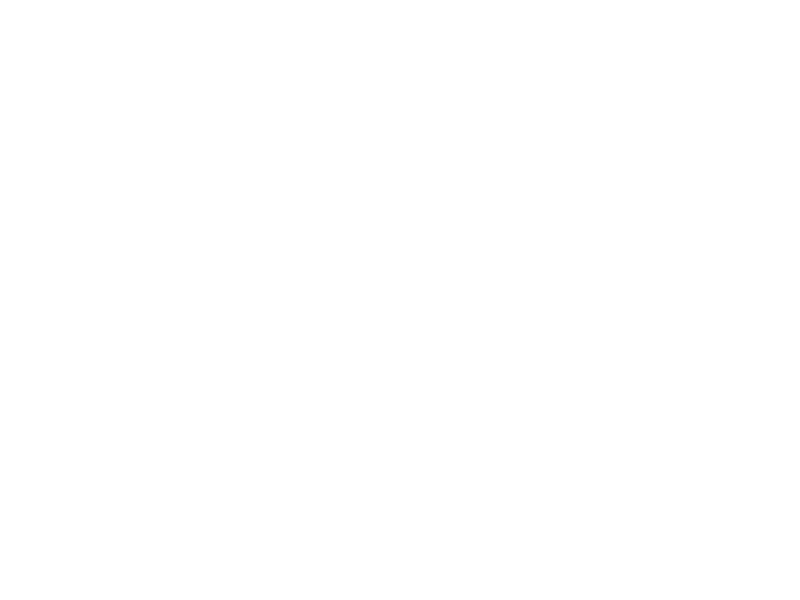

In [17]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(ts[0:50],x_pred[0:50],y_pred[0:50])
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
ax.set_title("After Kalman Smoothing")
plt.show()

In [18]:
from numpy.linalg import inv
import filterpy.kalman

def tracker_4dof(noise=0.02, time=1.0):
    q = noise
    dt = time
    tracker = filterpy.kalman.KalmanFilter(dim_x=8, dim_z=2)
    tracker.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    tracker.F = np.array([[1., 0., dt, 0., 1 / 2 * (dt ** 2), 0., 1 / 6 * (dt ** 3), 0],
                          [0., 1., 0., dt, 0., 1 / 2 * (dt ** 2), 0., 1 / 6 * (dt ** 3)],
                          [0., 0., 1., 0., dt, 0., 1 / 2 * (dt ** 2), 0],
                          [0., 0., 0., 1., 0, dt, 0., 1 / 2 * (dt ** 2)],
                          [0., 0., 0., 0., 1., 0., dt, 0.],
                          [0., 0., 0., 0., 0, 1., 0., dt],
                          [0., 0., 0., 0., 0, 0., 1., 0.],
                          [0., 0., 0., 0., 0, 0., 0., 1.]])
    tracker.H = np.array([[1., 0., 0., 0., 0., 0., 0., 0.],
                          [0., 1., 0., 0., 0., 0., 0., 0.],])
    tracker.R = np.array([[1.0, 0],
                          [0, 1.0]])
    tracker.P = np.eye(8) * 1000.
    tracker.Q = np.array([[0., 0., q, 0., q, 0., q, 0.],
                          [0., 0., 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q]])
    return tracker


def tracker_3dof(noise=0.02, time=1.0):
    q = noise
    dt = time
    tracker = filterpy.kalman.KalmanFilter(dim_x=6, dim_z=2)
    tracker.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    tracker.F = np.array([[1., 0., dt, 0., 1 / 2 * (dt ** 2), 0.],
                          [0., 1., 0., dt, 0., 1 / 2 * (dt ** 2)],
                          [0., 0., 1., 0., dt, 0.],
                          [0., 0., 0., 1., 0, dt],
                          [0., 0., 0., 0., 1., 0.],
                          [0., 0., 0., 0., 0, 1.]])
    tracker.H = np.array([[1., 0., 0., 0., 0., 0.],
                          [0., 1., 0., 0., 0., 0.],])
    tracker.R = np.array([[1., 0],
                          [0, 1.]])
    tracker.P = np.eye(6) * 1000.
    tracker.Q = np.array([[0., 0., q, 0., q, 0.],
                          [0., 0., 0., q, 0., q],
                          [q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q]])
    return tracker


def tracker_2dof(noise=0.01, time=1.0):
    q = noise
    dt = time
    tracker = filterpy.kalman.KalmanFilter(dim_x=4, dim_z=2)
    tracker.x = np.array([0.0, 0.0, 0.0, 0.0])
    tracker.F = np.array([[1., 0., dt, 0.],
                          [0.,1., 0., dt],
                          [0., 0., 1., 0.],
                          [0., 0., 0., 1.]])
    tracker.H = np.array([[1., 0., 0., 0.],
                          [0., 1., 0., 0.]])
    tracker.R = np.array([[1., 0],
                          [0, 1.]])
    tracker.P = np.eye(4) * 1000.
    tracker.Q = np.array([[0, 0., q, 0.],
                          [q, 0., q, 0.],
                          [0., 0., 0., q],
                          [0., q, 0., q]])
    return tracker


In [19]:
x = np.array(data['norm_pos_x'])
y = np.array(data['norm_pos_y'])
t = np.array(data['timestamp'])


skip = 10000
step = 200
KF = tracker_4dof()
preds = []
measure = []
time = []
z = np.array([x[skip], y[skip]])
count = [_ for _ in range(step)]
eps_max = 0.6
scale = 10
dumb = 0
old_Q = KF.Q

for _ in range(skip, skip+step):

    KF.predict()
    KF.update(z)
    preds.append([KF.x[0], KF.x[1]])
    measure.append([z[0], z[1]])
    time.append(t[_])
    z = np.array([x[_], y[_]])
    # res_x.append(KF_2D.y[0])
    # res_y.append(KF_2D.y[1])
    res = KF.y
    S = KF.S
    eps = np.dot(res.T, inv(S)).dot(res)
    if eps > eps_max:
        KF.Q = old_Q*scale
        dumb += 1
    elif dumb > 0:
        KF.Q = old_Q
        dumb = dumb - 1

print("{}, {}, {}".format(len(preds), len(measure), len(time)))

200, 200, 200


<IPython.core.display.Javascript object>


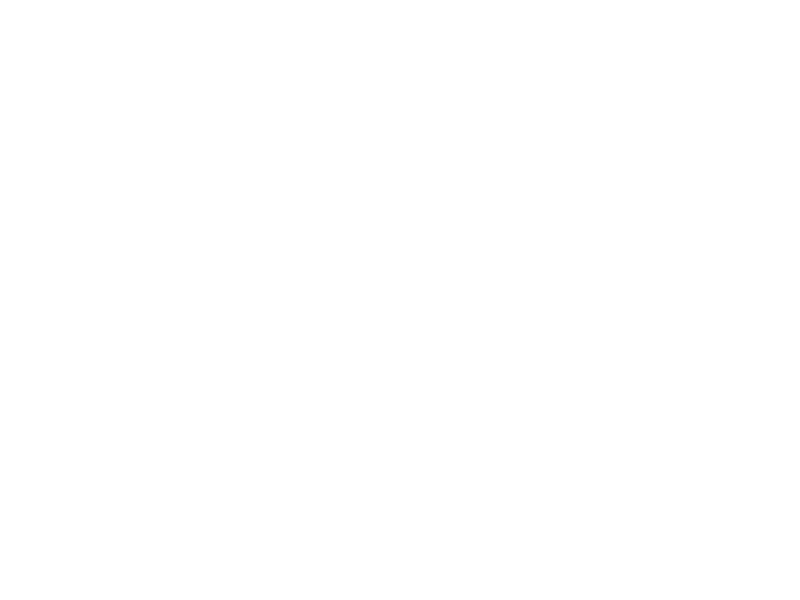

In [20]:
%matplotlib notebook
plt.subplot(2,1,1)
# plt.xlim(0,1280)
# plt.ylim(0,720)
plt.title('With Kalman Filter')
plt.scatter([preds[_][0] for _ in range(len(preds))], [preds[_][1] for _ in range(len(preds))], color='green', marker='.')


plt.subplot(2,1,2)
# plt.xlim(0,1280)
# plt.ylim(0,720)
plt.title('Without Kalman Filter')
plt.scatter([measure[_][0] for _ in range(len(measure))], [measure[_][1] for _ in range(len(measure))], color='blue', marker='.')

plt.show()

<IPython.core.display.Javascript object>


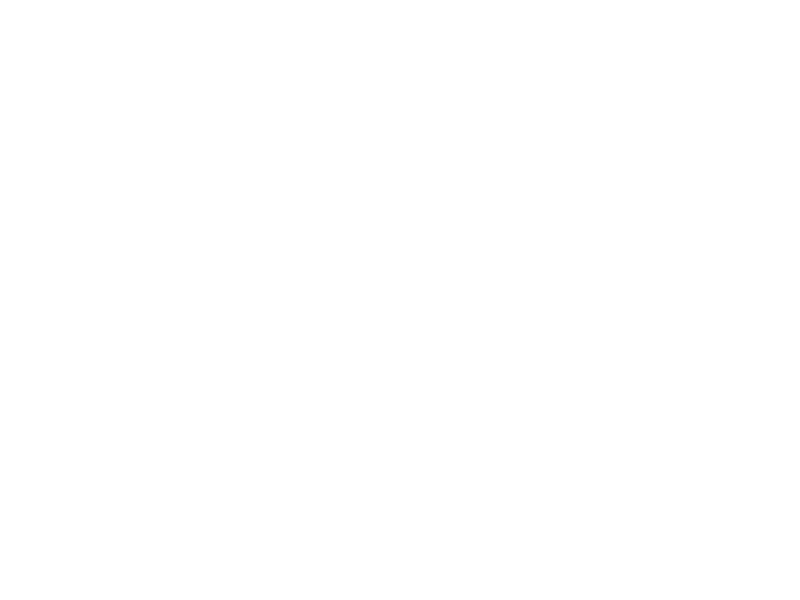

In [21]:
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(time,[preds[_][0] for _ in range(len(preds))], [preds[_][1] for _ in range(len(preds))], color="green")
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
ax.set_title("After Kalman Smoothing")
plt.show()

<IPython.core.display.Javascript object>


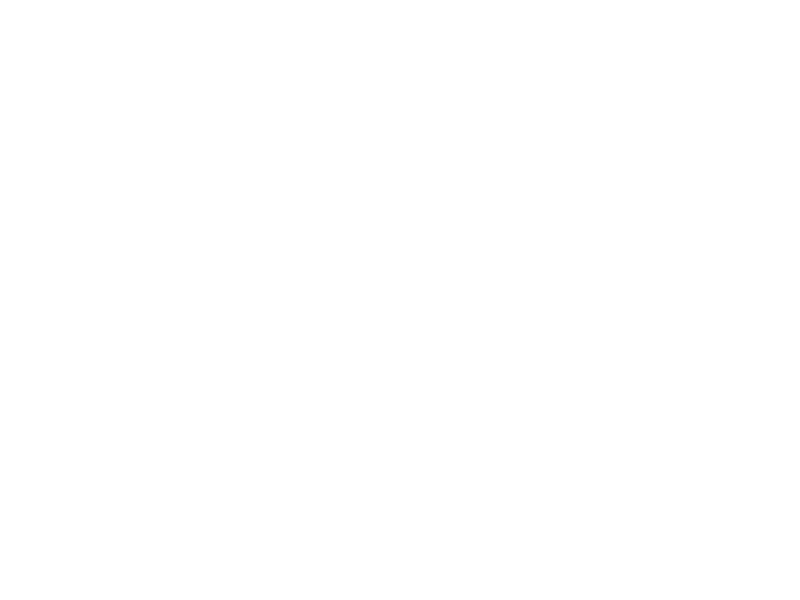

In [22]:
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(time,[measure[_][0] for _ in range(len(measure))], [measure[_][1] for _ in range(len(measure))])
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
ax.set_title("Without Kalman Smoothing")
plt.show()

In [23]:
from pykalman import KalmanFilter
xy = data[["norm_pos_x", "norm_pos_y"]].values
kf = KalmanFilter(initial_state_mean=[1,1.5],n_dim_obs=2)
output = kf.em(xy[skip:skip+step]).smooth(xy[skip:skip+step])
xy_new = output[0]
x_pred = xy_new[:,0]
y_pred = xy_new[:,1]

<IPython.core.display.Javascript object>


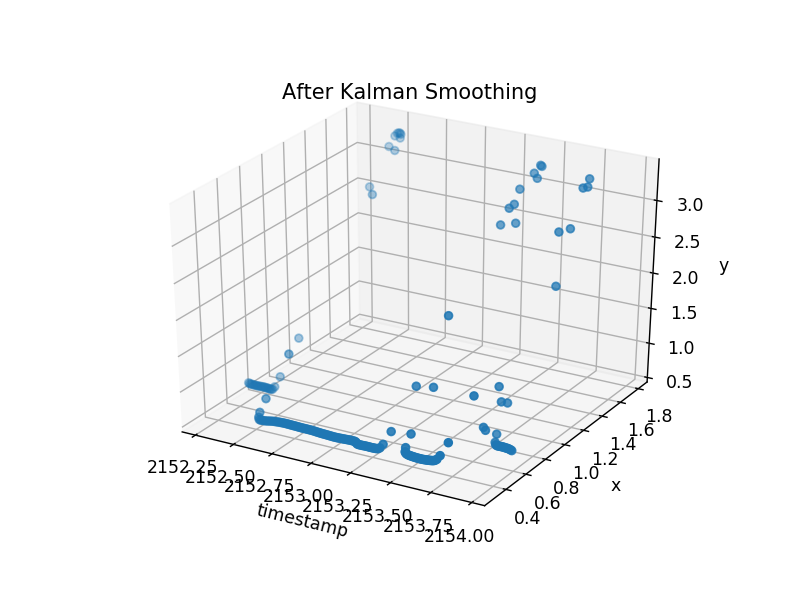

In [24]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(time,x_pred,y_pred)
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
ax.set_title("After Kalman Smoothing")
plt.show()

In [42]:
def distance(c1, c2):
    return np.sqrt((c2[0]-c1[0]) ** 2 + (c2[1]-c1[1]) ** 2)

def segment_data(x, y, t, threshold=5):
    f_x = []
    f_y = []
    f_t = []
    
    pt1 = (x[0], y[0])
    pt2 = (x[1], y[1])
    old_vel = distance(pt1, pt1) / (t[1] - t[0])
    t1 = t[0]
    pt1 = pt2

    p_x = [x[0]]
    p_y = [y[0]]
    p_t = [t[0]]
    
    if old_vel == 0:
        old_vel = 0.2
    i=0
    for x2,y2,t2 in zip(x[1:],y[1:],t[1:]):
        pt2 = (round(x2, 4),round(y2, 4))
        new_vel = distance(pt1, pt2) / (t2-t1)
                
        if new_vel < 10.0 or new_vel < (threshold * old_vel):
            p_x.append(x2)
            p_y.append(y2)
            p_t.append(t2)
            if new_vel != 0: 
                old_vel = new_vel
        else:
            f_x.append(p_x)
            f_y.append(p_y)
            f_t.append(p_t)
            p_x = [x2]
            p_y = [y2]
            p_t = [t2]
            i += 1
        
        pt1 = pt2
        t1 = t2

    return f_x, f_y, f_t

def smoothen_data(x, y, t, num_pts=10):
    
    def smoothen(l, np):
        nl =[]
        for part in l:
            if len(part) > np:
                nl.extend(part)
        return nl
    
    return smoothen(x, num_pts), smoothen(y, num_pts), smoothen(t, num_pts)

In [27]:
len(fy)

10

<IPython.core.display.Javascript object>


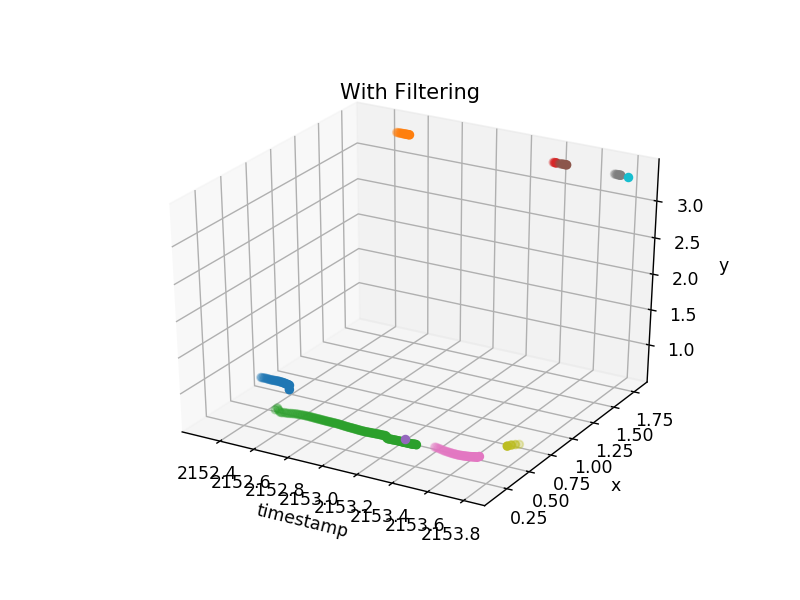

In [28]:
plt.figure()
ax = plt.axes(projection='3d')
for _x, _y, _t in zip(fx, fy, ft):
    ax.scatter3D(_t, _x, _y)
# ax.scatter3D(t[skip:skip+step], x[skip:skip+step], y[skip:skip+step])
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
ax.set_title("With Filtering")
plt.show()

In [29]:
max(data['norm_pos_y'])

3.363194168974432

In [30]:
from numpy.linalg import inv
import filterpy.kalman

def tracker_4dof(noise=0.02, time=1.0):
    q = noise
    dt = time
    tracker = filterpy.kalman.KalmanFilter(dim_x=8, dim_z=2)
    tracker.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    tracker.F = np.array([[1., 0., dt, 0., 1 / 2 * (dt ** 2), 0., 1 / 6 * (dt ** 3), 0],
                          [0., 1., 0., dt, 0., 1 / 2 * (dt ** 2), 0., 1 / 6 * (dt ** 3)],
                          [0., 0., 1., 0., dt, 0., 1 / 2 * (dt ** 2), 0],
                          [0., 0., 0., 1., 0, dt, 0., 1 / 2 * (dt ** 2)],
                          [0., 0., 0., 0., 1., 0., dt, 0.],
                          [0., 0., 0., 0., 0, 1., 0., dt],
                          [0., 0., 0., 0., 0, 0., 1., 0.],
                          [0., 0., 0., 0., 0, 0., 0., 1.]])
    tracker.H = np.array([[1., 0., 0., 0., 0., 0., 0., 0.],
                          [0., 1., 0., 0., 0., 0., 0., 0.],])
    tracker.R = np.array([[1.0, 0],
                          [0, 1.0]])
    tracker.P = np.eye(8) * 1000.
    tracker.Q = np.array([[0., 0., q, 0., q, 0., q, 0.],
                          [0., 0., 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q]])
    return tracker

In [31]:
def kalman(KF, x, y, t):
    preds_x = []
    preds_y = []
    measure = []
    time = []
    z = np.array([x[0], y[0]])
    count = [_ for _ in range(step)]
    eps_max = 0.6
    scale = 10
    dumb = 0
    old_Q = KF.Q

    for i in range(1,len(x)):
        KF.predict()
        KF.update(z)
        preds_x.append(KF.x[0])
        preds_y.append(KF.x[1])
        measure.append([z[0], z[1]])
        time.append(t[i])
        z = np.array([x[i], y[i]])
        res = KF.y
        S = KF.S
        eps = np.dot(res.T, inv(S)).dot(res)
        if eps > eps_max:
            KF.Q = old_Q*scale
            dumb += 1
        elif dumb > 0:
            KF.Q = old_Q
            dumb = dumb - 1
            
    return preds_x, preds_y, time

In [32]:
predicted_x = []
predicted_y = []
predicted_t = []
measure= []
for _x, _y, _t in zip(fx, fy, ft):
    print(len(_x), len(_y), len(_t))
    p_x, p_y, p_t = kalman(tracker_4dof(), _x, _y, _t)
    predicted_x.append(p_x)
    predicted_y.append(p_y)
    predicted_t.append(p_t)

23 23 23
10 10 10
98 98 98
3 3 3
1 1 1
6 6 6
31 31 31
5 5 5
4 4 4
1 1 1


<IPython.core.display.Javascript object>


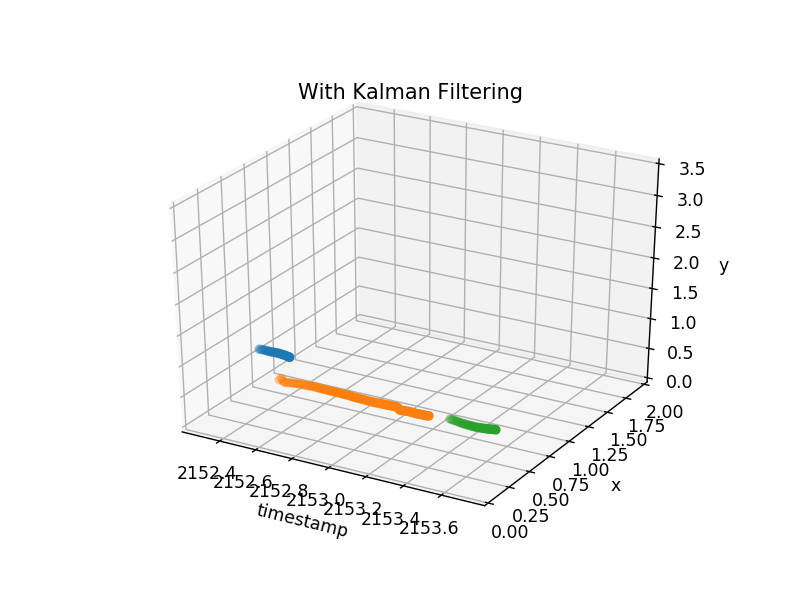

In [40]:
plt.figure()
ax = plt.axes(projection='3d')
for _x, _y, _t in zip(predicted_x, predicted_y, predicted_t):
    if (len(_x) > 10):
        ax.scatter3D(_t, _x, _y)
# ax.scatter3D(t[skip:skip+step], x[skip:skip+step], y[skip:skip+step])
ax.set_ylim(0,2)
ax.set_zlim(0,3.5)
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_title("With Kalman Filtering")
plt.show()

In [60]:
sx, sy, st = smoothen_data(fx, fy, ft, num_pts=10)

In [61]:
p_sx, p_sy, p_st = kalman(tracker_4dof(), sx, sy, st)

<IPython.core.display.Javascript object>


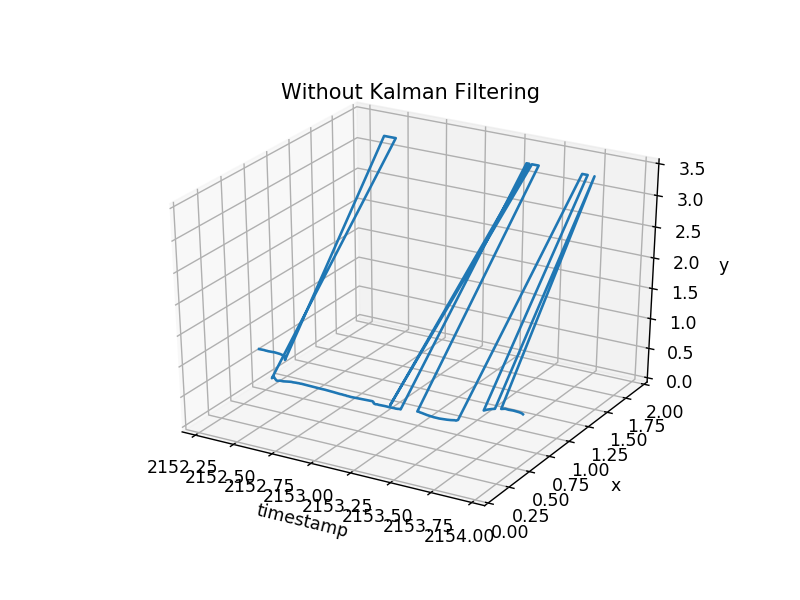

<IPython.core.display.Javascript object>


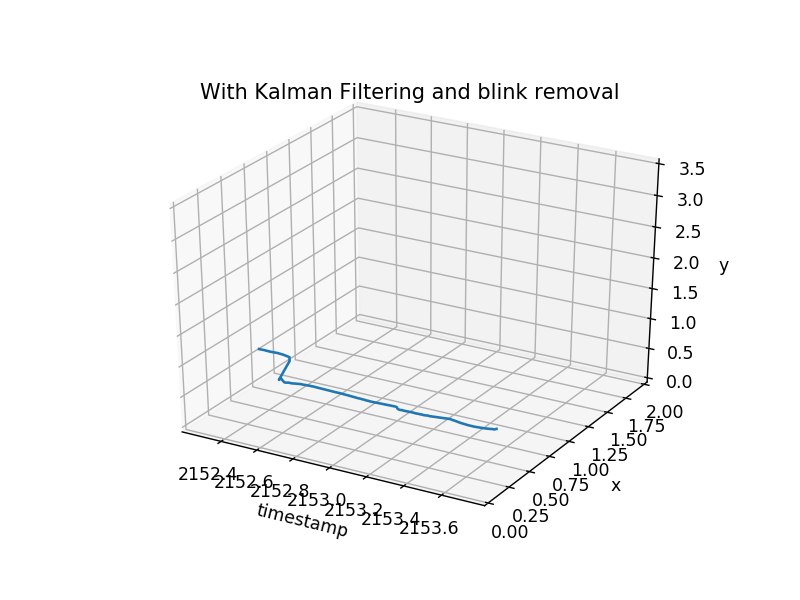

In [62]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(t[skip:skip+step], x[skip:skip+step], y[skip:skip+step])
ax.set_ylim(0,2)
ax.set_zlim(0,3.5)
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_title("Without Kalman Filtering")
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(st, sx, sy)
ax.set_ylim(0,2)
ax.set_zlim(0,3.5)
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_title("With Kalman Filtering and blink removal")
plt.show()